In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv


In [3]:
def downsample_image(img):
  width, height = img.size
  aspect_ratio = width / height
  if width > height:
      target_width =640
      target_height = math.floor(640 / aspect_ratio)
  else:
      target_height = 640
      target_width = math.floor(640 * aspect_ratio)
  return img.resize((target_width, target_height))

In [4]:
def convert_to_grayscale(img):
    return img.convert("L")


In [5]:
def convolve_laplacian(image, kernel = 5):
    """
    Convolves a median filtered image with a Laplacian filter.
    """

    image_array = np.array(image)
    rows, cols = image_array.shape
    filtered_image = np.zeros_like(image_array)

    # Apply a 5x5 Laplacian kernel
    if kernel == 5:
      laplacian_kernel = np.array([
          [0, 0, -1, 0, 0],
          [0, -1, -2, -1, 0],
          [-1, -2, 16, -2, -1],
          [0, -1, -2, -1, 0],
          [0, 0, -1, 0, 0]
      ])
    elif kernel == 3:
      laplacian_kernel = np.array([
      [0, -1, 0],
      [-1, 4, -1],
      [0, -1, 0]
      ])
    else:
      raise ValueError("Kernel invalid, kernel value should be 3 or 5")


    # Convert image to numpy array
    edge_size = kernel // 2

    # pad the image_array
    image_array = np.pad(image_array, pad_width=edge_size, mode='symmetric')

    # Get image dimensions (after padding)
    rows, cols = image_array.shape


    # Apply convolution (excluding borders to avoid index errors)
    for i in range(edge_size, rows - edge_size):
        for j in range(edge_size, cols - edge_size):
          neighborhood = image_array[i-edge_size:i+edge_size+1, j-edge_size:j+edge_size+1]
          filtered_value = np.sum(neighborhood * laplacian_kernel)
          filtered_image[i-edge_size, j-edge_size] = 255 - np.clip(filtered_value, 0, 255)

    # Convert back to PIL Image
    filtered_image = Image.fromarray(filtered_image.astype(np.uint8))
    return filtered_image

In [6]:
def median_filter(image, kernel_size = 3):
    """
    Applies a kernel_size x kernel_size median filter to the image.
    The kernel size must be an odd number.
    Additionally, the image is padded first with symmetric padding
    Args:
        image: A PIL Image object.

    Returns:
        A PIL Image object with the median filter applied.
    """

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Create a new array for the filtered image
    filtered_image = np.zeros_like(image_array)

    # Half kernel length exluding the center
    edge_size = kernel_size // 2

    # pad the image_array
    image_array = np.pad(image_array, pad_width=edge_size, mode='symmetric')

    # Get image dimensions (after padding)
    rows, cols = image_array.shape

    # Iterate over the image pixels, excluding the borders
    for i in range(edge_size, rows-edge_size):
        for j in range(edge_size, cols - edge_size):
            # Extract a kernel_size x kernel_size neighborhood around the current pixel
            neighborhood = image_array[i-edge_size:i+edge_size+1, j-edge_size:j+edge_size+1]
            # Calculate the median of the neighborhood
            median = np.median(neighborhood)
            filtered_image[i-edge_size, j-edge_size] = median

    # Convert back to PIL image
    filtered_image = Image.fromarray(filtered_image.astype(np.uint8))
    return filtered_image

In [10]:
def Median_filter_with_frequency(image, frequency_array):
    """
    Applies a 3x3 median filter to the image, taking into account a given frequency array.

    Args:
        image: A PIL Image object.
        frequency_array: A 3x3 array of integers representing the frequency weight of each pixel in the filter.

    Returns:
        A PIL Image object with the median filter applied.
    """

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Get image dimensions
    rows, cols = image_array.shape

    # Create a new array for the filtered image
    filtered_image = np.zeros_like(image_array)

    # Iterate over the image pixels, excluding the borders
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Extract a 3x3 neighborhood around the current pixel
            neighborhood = image_array[i-1:i+2, j-1:j+2]

            # Flatten the neighborhood and corresponding frequency array
            flattened_neighborhood = neighborhood.flatten()
            flattened_frequency = frequency_array.flatten()

            # Repeat the values according to their frequencies
            weighted_values = np.repeat(flattened_neighborhood, flattened_frequency)

            # Calculate the median of the weighted values
            median = np.median(weighted_values)
            filtered_image[i, j] = median

    # Convert back to PIL image
    filtered_image = Image.fromarray(filtered_image.astype(np.uint8))
    return filtered_image


In [130]:
import numpy as np
from PIL import Image

def apply_binary_threshold(image, threshold=122):
    """
    Applies a binary threshold to an image.
    If the pixel value is above the threshold, it is set to 255; otherwise, it is set to 0.

    Args:
        image: A PIL Image object (grayscale).
        threshold: The threshold value. Default is 122.

    Returns:
        A PIL Image object with the binary threshold applied.
    """
    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Apply the binary threshold
    binary_image = np.where(image_array < threshold, 255, 0)

    # Convert the result back to a PIL Image
    binary_image = Image.fromarray(binary_image.astype(np.uint8))
    return binary_image


In [50]:
def expand_edges(edge_image, kernel_size=3):
    """
    Expands the edges in the image according to kernel_size by using a filter of
    all ones and then clipping

    Args:
        image: A PIL Image object (grayscale) of shape (Height, Width)
        kernel_size: The size of the kernel to use. Default is 3.

    Returns:
        A PIL Image object with the binary threshold applied.
    """
    edge_image = np.array(edge_image)
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)

    filtered_image = np.zeros_like(edge_image)

    # Half kernel length excluding the center
    edge_size = kernel_size // 2

    # pad the image_array
    edge_image = np.pad(edge_image, pad_width=edge_size, mode='symmetric')

    # Get image dimensions (after padding)
    rows, cols = edge_image.shape
    print(np.unique(edge_image))
    # Convolve kernel with edge image then clip to be between (0, 255)
    for i in range(edge_size, rows - edge_size):
        for j in range(edge_size, cols - edge_size):
          neighborhood = edge_image[i-edge_size:i+edge_size+1, j-edge_size:j+edge_size+1]
          filtered_value = np.sum((neighborhood) * kernel)
          filtered_image[i-edge_size, j-edge_size] = 255 - np.clip(filtered_value, 0, 255)

    return Image.fromarray(filtered_image)

In [47]:
def preview(img, gray=True):
    """
    Displays an image. If the image is grayscale, it will be shown in grayscale mode.

    Args:
        img: The image to display (can be a NumPy array or PIL Image).
        gray: Boolean flag to indicate if the image should be displayed in grayscale.
    """
    # Ensure img is a NumPy array if it's a PIL Image
    if isinstance(img, Image.Image):
        img = np.array(img)

    # Check the shape of the image data
    if gray:
        if img.ndim != 2:
            raise TypeError("Invalid shape for grayscale image: expected 2D array.")
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:
        if img.ndim != 3 or img.shape[-1] not in [3, 4]:
            raise TypeError("Invalid shape for color image: expected 3D array with 3 or 4 channels.")
        plt.imshow(img)

    plt.axis('off')  # Hide axis
    plt.show()


In [43]:
def bilateral_filter(img, d=9, sigma_color=25, sigma_space=25, repetitions=5):
    """
    Applies a bilateral filter to an image.

    Args:
        img: A PIL Colored Image object.

    Returns:
        A PIL Image object with the bilateral filter applied.
    """
    # Convert the PIL image to a numpy array and verify its properties
    img_np = np.array(img)

    # Convert RGBA to RGB if necessary
    if img_np.shape[2] == 4:  # RGBA format
        img_np = cv.cvtColor(img_np, cv.COLOR_RGBA2RGB)

    # Apply the bilateral filter multiple times
    for _ in range(repetitions):
        img_np = cv.bilateralFilter(img_np, d, sigma_color, sigma_space, borderType=cv.BORDER_DEFAULT)

    return Image.fromarray(img_np)

In [121]:
def combine_edge_bilateral(img_edge, img_bilateral, d=11, sigma_color=75, sigma_space=75,expanded = False):
    """
    Combines the Edge Image with the Bilateral Filtered Image .

    Args:
        img_edge: A PIL greyscale image.
        img_bilateral: A PIL Colored Image object.

    Returns:
        A PIL Image object with the bilateral filter emphasized with edges.
    """
    # Convert edge map to be (0 to 1) instead of (0 to 255)
    img_edge = (np.array(img_edge)/255).astype(np.uint8)

    # Convert image edge from (Height, Width) tp (Height, Width, 3)
    img_edge = np.repeat(img_edge[:, :, np.newaxis], 3, axis=2)

    img_bilateral = np.array(img_bilateral)



    # Convert RGBA to RGB if necessary
    if img_bilateral.shape[2] == 4:  # RGBA format
        img_bilateral = cv.cvtColor(img_bilateral, cv.COLOR_RGBA2RGB)

    # Multiply both arrays element wise to get the emphasis over the edges
    if expanded:
        combined_image = (img_edge) * img_bilateral
    else:
        combined_image = (1-img_edge) * img_bilateral

    return Image.fromarray(combined_image)

# to present our work, we will use Thutmoses black granite statue from the Egyptian Grand Museum showroom


In [16]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
img = Image.open(fn)

ModuleNotFoundError: No module named 'google'

In [11]:
path = r"C:\Users\youss\Documents\GitHub\Image-Cartoonification\thutmoses.jpg"

In [12]:
img = downsample_image(Image.open(path))

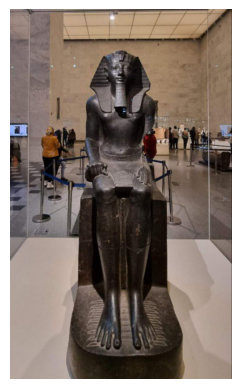

image size = (383, 640)


In [13]:
preview(img,gray = False)
print(f"image size = {img.size}")

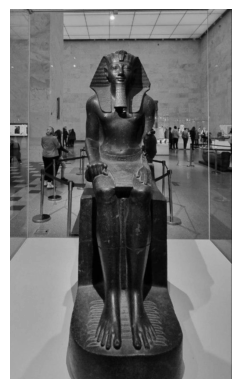

In [14]:
gray = convert_to_grayscale(img)
preview(gray)

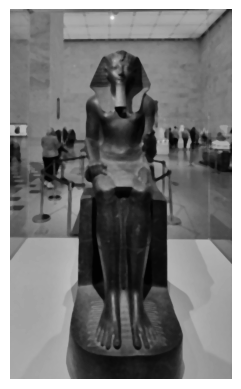

In [15]:
median = median_filter(gray, kernel_size=5)
preview(median)

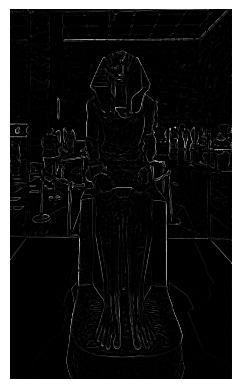

In [23]:
convolved_image = cv.Laplacian(np.array(median),cv.CV_64F,ksize = 3)
preview(convolved_image)

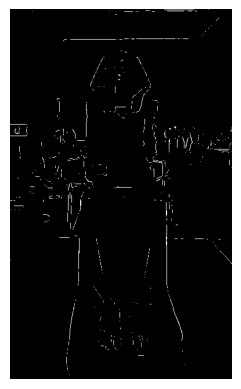

In [53]:
threshold = apply_binary_threshold(convolved_image,threshold = 130)
preview(threshold)

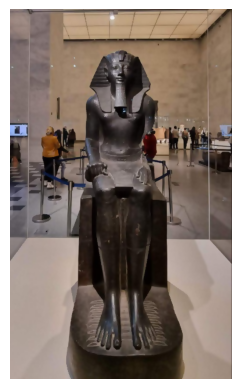

In [27]:
blur = bilateral_filter(img,d=3, repetitions=7)
preview(blur,gray=False)

[  0 255]


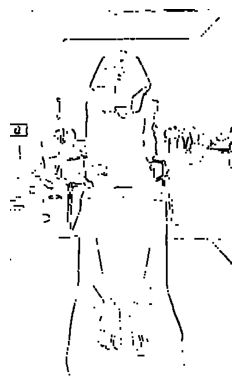

In [54]:
expanded_edges = expand_edges(threshold, kernel_size=3)
preview(expanded_edges)

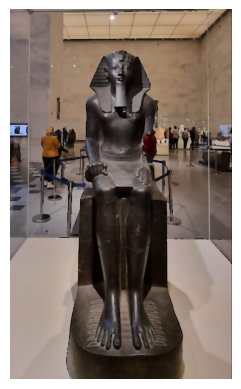

In [55]:
cartoon_image = combine_edge_bilateral(threshold,blur)
preview(cartoon_image,gray=False)

# Test on the same image provided in the assignment

In [56]:
path2 = r"C:\Users\youss\Documents\GitHub\Image-Cartoonification\org.png"
img = Image.open(path2)

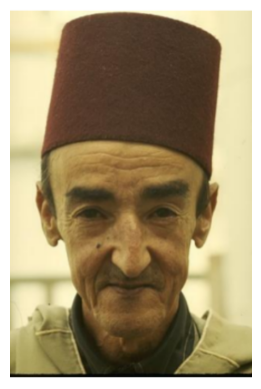

image size = (284, 434)


In [57]:
preview(img,gray = False)
print(f"image size = {img.size}")

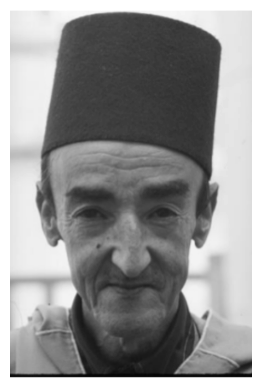

(284, 434)


In [58]:
gray_img = convert_to_grayscale(img)
preview(gray_img)
print(gray_img.size)

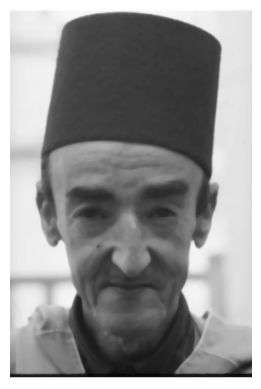

(284, 434)


In [59]:
median_filtered_image = median_filter(gray_img, kernel_size=5)
preview(median_filtered_image)
print(median_filtered_image.size)

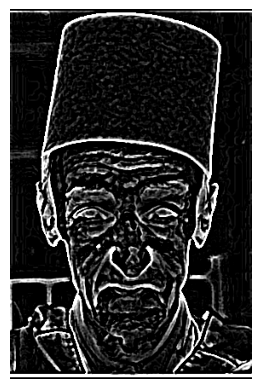

In [128]:
convolved_image_5 = cv.Laplacian(np.array(median_filtered_image),cv.CV_8U, ksize = 5)
preview(convolved_image_5)

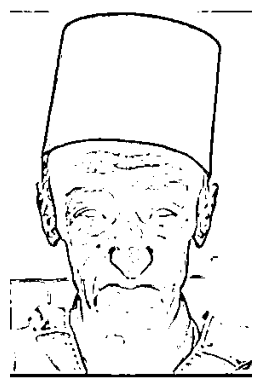

In [139]:
threshold = apply_binary_threshold(convolved_image_5,threshold = 190)
preview(threshold)

[  0 255]


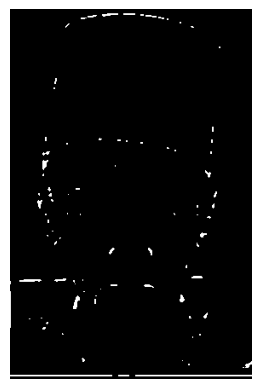

In [132]:
expanded_edges = median_filter(expand_edges(threshold, kernel_size=3),3)#useful for scaling edges for huge objects
preview(expanded_edges)

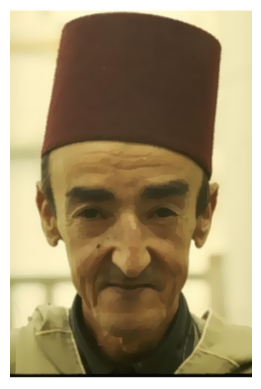

In [74]:
blur = bilateral_filter(img=img, d=7,sigma_color=11, sigma_space=20, repetitions=4)
preview(blur,gray=False)

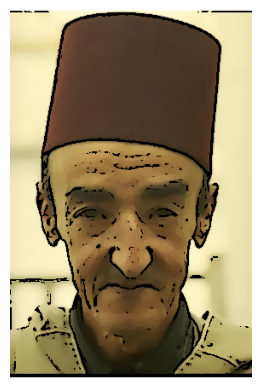

In [140]:
cartoon_image = combine_edge_bilateral(threshold,blur,expanded = True)
preview(cartoon_image,gray=False)